<a href="https://colab.research.google.com/github/yuvalofek/Digital-Image-Processing/blob/main/LapSRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook implementation of LapSRN
Deep Laplacian Pyramid Networks for Fast and Accurate Super-Resolution

Arxiv: https://arxiv.org/pdf/1704.03915

Author Site: http://vllab.ucmerced.edu/wlai24/LapSRN/

## Dataset Setup

In [ ]:
# imports 

import zipfile as zp    #unzipping

# dataset creation
import os
from PIL import Image
import torch.utils.data as data
import numpy.random as npr
import numpy as np

# pytorch for augmentation and model
import torch 
import torchvision
from torchvision.transforms import Compose, ToTensor, Resize, RandomHorizontalFlip, RandomCrop, Normalize

# viz
import matplotlib.pyplot as plt

### Getting the Dataset
The authors of the paper provided their datasets as a downloadable zip file found at http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_training_datasets.zip

In the following cells we get the zipped file and extract it locally. I note that !wget is a collab specific way to run wget (to import the file). 

In [ ]:
# LapSRN dataset
!wget http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_training_datasets.zip

--2021-04-29 17:45:57--  http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_training_datasets.zip
Resolving vllab.ucmerced.edu (vllab.ucmerced.edu)... 169.236.184.69
Connecting to vllab.ucmerced.edu (vllab.ucmerced.edu)|169.236.184.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90427393 (86M) [application/zip]
Saving to: ‘SR_training_datasets.zip’

SR_training_dataset 100%[===================>]  86.24M  18.8MB/s    in 9.7s    

2021-04-29 17:46:07 (8.86 MB/s) - ‘SR_training_datasets.zip’ saved [90427393/90427393]



In [ ]:
# extract the file:
with zp.ZipFile('SR_training_datasets.zip') as myzip:
    myzip.extractall()

### Setting up the dataset
The paper described three methods of data augmentation used, which are as follows: 
* scale by factors in [0.5, 1.0]
* random rotation by 90 degree intervals
* flip image left-right & up-down

I note that for the dataset dataset I use, which has animals, up-down flips might not make sense. I perform up-down flips regardless, and do so through a composition of rotation, left-right flips, and additional rotations. 

I only use one of the provided datasets: BSDS200


In [ ]:
# parameters:
desired_image_size = 64   # originally 128 
dataset_path = '/content/BSDS200'
TEST_PERCENT = 0.2
NUM_TIMES = 8 # Number of times to sample each image
s = 2

In [ ]:
# randomly rotate the image by a factor of 90 degrees. 
class RandomRotate:
  def __call__(self, img):
    return img.rotate(90 * npr.randint(0, 4))


# Randomly zoom in on the image, keeping the output pixel count greater than 
# needed for cropping. 
class RandomScale:
  def __call__(self, img):
    shape = img.size
    # we don't want to scale bellow the point where we can crop an input image
    min_ratio = desired_image_size/min(shape)+0.1 # added a factor to guarrantee this will work
    ratio = npr.uniform(max(min_ratio, 0.5), 1.0)
    out_shape = (int(shape[0]*ratio), int(shape[1]*ratio))
    resized =  img.resize(out_shape, Image.BICUBIC)
    return resized

In [ ]:
# augment input (scale, crop, and flips)
def image_setup():
  transform = Compose([
                       RandomScale(),
                       RandomCrop(desired_image_size), 
                       RandomRotate(),
                       RandomHorizontalFlip(),
                       RandomRotate(),
  ])
  return transform

# downsample the image by a factor using bicubic interpolation
def downsample(down_factor):
  transform = Compose([
                       Resize(desired_image_size//down_factor, Image.BICUBIC),  # integer division
                       ToTensor()
  ])
  return transform


class DataSetter(data.Dataset):
  def __init__(self, file_names, s=3, image_sample_times=8):
    super(DataSetter, self).__init__()
    # list of file names
    # originally we want to create 64 sub-images from each original image (I do less)
    self.file_names = []
    [self.file_names.extend(file_names) for _ in range(image_sample_times)]
    # augmentation
    self.image_setup = image_setup()
    # downsampling
    self.downsampling = [downsample(2**factor) for factor in range(1, s+1)]
    self.to_tensor = ToTensor()

  def __getitem__(self, index):
    # get the image
    img = Image.open(self.file_names[index]).convert('YCbCr')
    # to grayscale
    y, _, _ = img.split()
    
    # normalize image
    y = Image.fromarray((y-np.mean(y))/np.std(y))

    # augment
    aug = self.image_setup(y)
    
    # downsample as many times as needed
    downsamples = [self.to_tensor(aug)]
    for down_factor in self.downsampling:
      downsamples.append(down_factor(aug))

    #return image and downsampled versions as a tuple
    return tuple(downsamples)

  def __len__(self):
    return len(self.file_names)


In [ ]:
# get all the file names for the files in the directory
file_names = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path)]
# shuffle the inputs
num_inputs = len(file_names)
shuffle = npr.permutation(num_inputs)
file_names = [file_names[i] for i in shuffle]

# make the two datasets based on the earlier set parameters
tr_ds = DataSetter(file_names[int(num_inputs*TEST_PERCENT):], s=s, image_sample_times=NUM_TIMES)
val_ds = DataSetter(file_names[:int(num_inputs*TEST_PERCENT)], s=s,image_sample_times=NUM_TIMES)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


### Checks

In [ ]:
val = data.DataLoader(val_ds, batch_size=16, shuffle=True)

# check that the images are the right sizes and that the length makes sense
print('Sizes of images:')
[print(i.size()) for i in next(iter(val))]
print(f'Size of val set: {len(val)}')
print(f'Size of training set: {len(tr_ds)}')

Sizes of images:
torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 16, 16])
Size of val set: 20
Size of training set: 1280


Visualize the elements of the dataset

Sample image and its downsampled versions


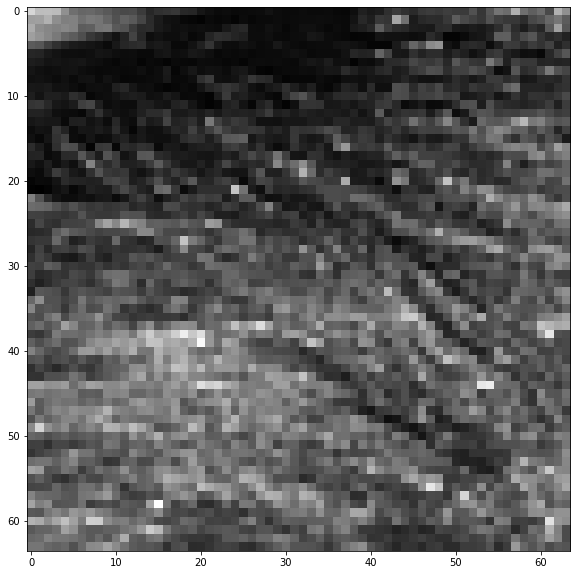

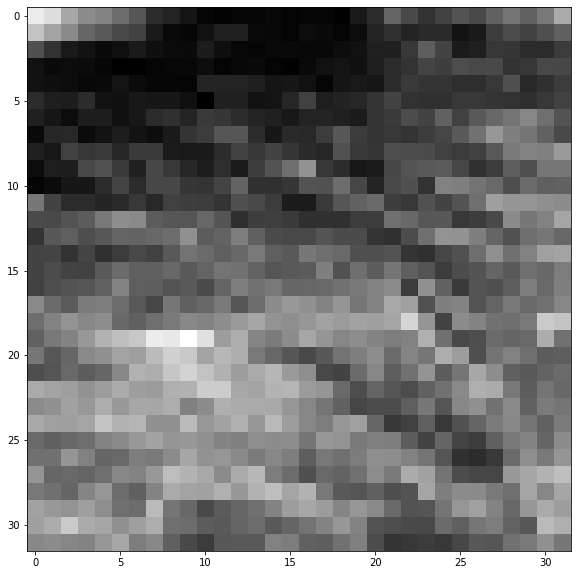

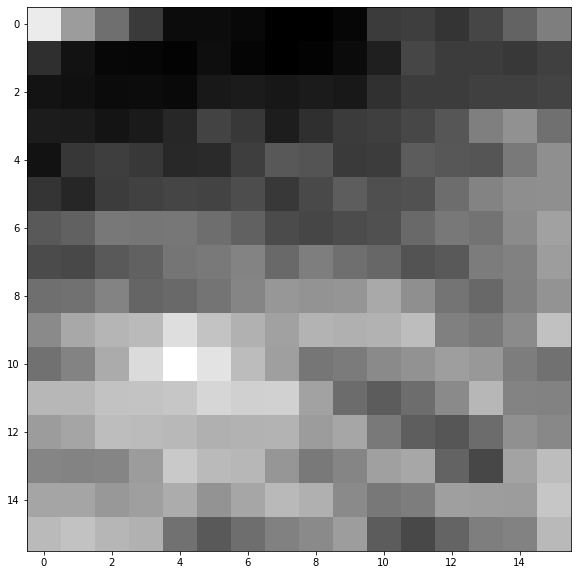

In [ ]:
it = iter(val)
first = next(it)

print('Sample image and its downsampled versions')
for i in range(s+1):
  plt.figure(figsize=(10,10))
  plt.imshow(first[i].numpy()[0][0], cmap='gray')

## Model

Here I incrementally build up a generalized form of the LapSRN model through the creation of the feature extraction and image reconstruction sub-networks. For Feature extraction and the overall network I include 2 different implementation, generalized and non-generalized, the prior being post-pended by a G to indicate 'generalized'. The generalized modules use input parameters to construct networks of varying sizes, while the non-generalized are size specific and make experimentation more difficult. 

Layer parameter values are found in the paper or calculated so the network performs as expected (this only included the stride for the transposed convolutions). 

I used bilinear initialization as has been formulated in  a different implementation I found online, specifically https://github.com/EdwardTyantov/LapSRN/blob/master/model.py as I was more interested in learning about the model than this type of initialization. 



In [ ]:
# same as the git clone command, but ! works on collab
# imports the pytorch-summary module which lets us display nice metrics for the 
# models created
!git clone https://github.com/sksq96/pytorch-summary

fatal: destination path 'pytorch-summary' already exists and is not an empty directory.


In [ ]:
# Import specific layers we want and summary 
from torch.nn import Conv2d, LeakyReLU, ConvTranspose2d, ModuleList
from torchsummary import summary

In [ ]:
# Model parameters:
FILTERS = 64
C_KERNEL = (3,3)
TC_KERNEL = (4,4)
TC_STRIDE = (2,2)
PADDING = (1,1)

In [ ]:
# I got a bit lost trying to find a bilinear intialized for pytorch kernels
# and opted to spend my work on other parts of the project - so I took an 
# existing implementation of the initializer that can be found here:
# https://github.com/EdwardTyantov/LapSRN/blob/master/model.py

def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    https://warmspringwinds.github.io/tensorflow/tf-slim/2016/11/22/upsampling-and-image-segmentation-with-tensorflow-and-tf-slim/
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(filter_size, weights):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    f_out = weights.size(0)
    f_in = weights.size(1)
    weights = np.zeros((f_out,
                        f_in,
                        4,
                        4), dtype=np.float32)

    upsample_kernel = upsample_filt(filter_size)

    for i in range(f_out):
        for j in range(f_in):
            weights[i, j, :, :] = upsample_kernel
    return torch.Tensor(weights)

Size specific feature extraction network:

Has 10 convolutional layers followed by a transposed convolution. Each layer is fed into a leaky relu. 

In [ ]:
# Size Specific Feature Extraction Sub-network
class FeatureExtraction(torch.nn.Module):
  def __init__(self, is_initial=False):
    super(FeatureExtraction, self).__init__()
    
    # make all the convolutional layers
    if is_initial:
      self.conv0 = Conv2d(in_channels=1, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)
    else: 
      self.conv0 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)   
    self.conv1 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)     
    self.conv2 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)      
    self.conv3 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)      
    self.conv4 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)      
    self.conv5 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)      
    self.conv6 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)      
    self.conv7 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)      
    self.conv8 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)      
    self.conv9 = Conv2d(in_channels=FILTERS, out_channels=FILTERS, kernel_size=C_KERNEL, padding=PADDING)      
    # add a transposed convolution at the end
    self.tConv = ConvTranspose2d(in_channels=FILTERS,
                                 out_channels=FILTERS, 
                                 kernel_size=TC_KERNEL, 
                                 stride=TC_STRIDE, 
                                 padding=PADDING)
    # use bilinear initialization for the transposed conv
    self.tConv.weight.data.copy_(bilinear_upsample_weights(4, self.tConv.weight))

    # set up the leaky relu to the right value
    self.leaky_relu = LeakyReLU(negative_slope=0.2)
    
  def forward(self, x):
    # loop through the layers and follow each with a leaky relu
    out = self.leaky_relu(self.conv0(x))
    out = self.leaky_relu(self.conv1(out))
    out = self.leaky_relu(self.conv2(out))
    out = self.leaky_relu(self.conv3(out))
    out = self.leaky_relu(self.conv4(out))
    out = self.leaky_relu(self.conv5(out))
    out = self.leaky_relu(self.conv6(out))
    out = self.leaky_relu(self.conv7(out))
    out = self.leaky_relu(self.conv8(out))
    out = self.leaky_relu(self.conv9(out))
    out = self.leaky_relu(self.tConv(out))
    return out

#summary(FeatureExtraction(), (64, 8, 8))

Generalized feature extraction sub-network:

Has 'd' convolutional layers followed by a transposed convolution. Each layer is fed into a leaky relu. 

In [ ]:
# General FeatureExtraction Sub-network
class FeatureExtractionG(torch.nn.Module):
  def __init__(self, d=3, is_initial=False):
    super(FeatureExtractionG, self).__init__()
    
    # make all the convolutional layers
    self.layers = ModuleList()
    if is_initial:
      # if we are at the input layer we have 1 input channel
      self.layers.append(Conv2d(in_channels=1, out_channels=FILTERS, 
                                kernel_size=C_KERNEL, padding=PADDING))      
    for _ in range(d):
      self.layers.append(Conv2d(in_channels=FILTERS, out_channels=FILTERS, 
                                kernel_size=C_KERNEL, padding=PADDING))
    
    # add a transposed convolution at the end
    tConv = ConvTranspose2d(in_channels=FILTERS, 
                                       out_channels=FILTERS, 
                                       kernel_size=TC_KERNEL, 
                                       stride=TC_STRIDE, 
                                       padding=PADDING)
    # use bilinear initialization for the transposed conv
    tConv.weight.data.copy_(bilinear_upsample_weights(4, tConv.weight))
    self.layers.append(tConv)

    # set up the leaky relu to the right value
    self.leaky_relu = LeakyReLU(negative_slope=0.2)
    
  def forward(self, x):
    # loop through the layers and follow each with a leaky relu
    for layer in self.layers:
      x = self.leaky_relu(layer(x))
    return x

#summary(FeatureExtraction(), (64, 8, 8))

Image reconstruction subetwork:

Takes the lower res image and the output of a feature extraction network. The lower res gets upsampled with a transposed convolution while the output gets compined using a convolution. The outputs of which are added to produce the network output. 

In [ ]:
# Image Reconstruction Sub-network
class ImageReconstructionG(torch.nn.Module):
  def __init__(self):
    super(ImageReconstructionG, self).__init__()
    # transposed conv and initialization
    self.t_conv = ConvTranspose2d(in_channels=1, out_channels=1,
                                  kernel_size=TC_KERNEL, stride=TC_STRIDE,
                                  padding=PADDING)
    self.t_conv.weight.data.copy_(bilinear_upsample_weights(4, self.t_conv.weight))
    # normal conv
    self.conv = Conv2d(in_channels=FILTERS, out_channels=1, 
                       kernel_size=C_KERNEL, padding=PADDING) 

  def forward(self, m_dim, s_dim):
    residual = self.conv(m_dim) 
    upsample = self.t_conv(s_dim) 
    high_res =  residual+upsample
    
    return high_res
#summary(ImageReconstruction(), [(64, 16, 16), (1, 8, 8)])

Size specific LapSRN Network:

Has 2 stages of feature extraction and image reconstruction. The feature extraction sub-networks all have 10 convolutional layers.


In [ ]:
# Size Specific LapSRN Network
class LapSRN(torch.nn.Module):
  def __init__(self):
    super(LapSRN, self).__init__()
    # 2 extraction and reconstruction networks
    self.extraction1 = FeatureExtraction(is_initial=True)
    self.extraction2 = FeatureExtraction(is_initial=False)
    
    self.reconstruction1 = ImageReconstructionG()
    self.reconstruction2 = ImageReconstructionG()

  def forward(self, low_res):
    extr1 = self.extraction1(low_res)
    hr_2 = self.reconstruction1(extr1, low_res)

    extr2 = self.extraction2(extr1)
    hr_4 = self.reconstruction2(extr2, hr_2)
    
    return  [hr_2, hr_4]

#summary(LapSRN(s=s), (1, 64, 64))

General LapSRN Network:

Has 's' stages of feature extraction and image reconstruction. The feature extraction sub-networks all have 'd' convolutional layers.

In [ ]:
# General LapSRN Network
class LapSRNG(torch.nn.Module):
  def __init__(self, d=3, s=3):
    super(LapSRNG, self).__init__()
    # lists of extraction layers and reconstruction layers
    self.extraction = ModuleList([FeatureExtractionG(d=d, is_initial=i==0) for i in range(s)])
    self.reconstruction = ModuleList([ImageReconstructionG() for _ in range(s)])

  def forward(self, low_res):
    outputs = list()

    # take the output of the previous output of the feature extraction and 
    # push it into another feature extraction. Take the previously reconstructed
    # image and use it with the output of the feature extraction to create a new
    # higher resolution image using the image reconstruction network
    extracted = low_res.clone()
    for extr, recon in zip(self.extraction, self.reconstruction):
      extracted = extr(extracted)
      low_res = recon(extracted,low_res)
      outputs.append(low_res)
    return outputs

#summary(LapSRN(s=s), (1, 64, 64))

## Training

Here I create the training mechanism for the model. 

I do this in the form of a class: modeling

modeling has a fit function, which generally takes care of the entire training process. It also has a validation function to validate with an external dataset. 

In [ ]:
import torch.optim as opt
from torch.autograd import Variable
from tqdm import tqdm

In [ ]:
# model params
EPSILON = 1e-6  # 1e-3 squared
BATCH_SIZE = 16

In [ ]:
def CharbonnierLoss(predict, target):
  # As described in the paper 
  return torch.mean(torch.sqrt(torch.pow((predict-target), 2)+ EPSILON))

def MeanSquareError(predict, target):
  return torch.mean((target-predict)**2)

# class to take care of all the training
class modeling():
  def __init__(self, d=5, s=3, lr=1e-5):
    # save model params
    self.s = s
    self.d = d

    # initialize model & optimizer as well as set the loss function    
    self.model = LapSRNG(s=s, d=d)
    self.loss = CharbonnierLoss
    # momentum and weight_decay from the paper
    self.optimizer = opt.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 50, gamma=0.5)

    # if GPU is available
    self.cuda = torch.cuda.is_available()
    if self.cuda:
      self.model = self.model.cuda()

  def fit(self, training_set, epochs, batch_size=BATCH_SIZE, shuffle=True, validation_set=None, epoch_img=True):
    epoch_losses = []
    val_losses = []
    val_psnrs = [] 
    training_set = data.DataLoader(training_set, batch_size=batch_size, shuffle=shuffle)
    train_length = len(training_set)

    if validation_set is not None:
      validation_set = data.DataLoader(validation_set, batch_size=batch_size, shuffle=shuffle)

    for epoch in range(epochs):
      epoch_loss = 0.0

      # which batch to print from 
      rand_batch_idx = npr.randint(train_length)
      
      with tqdm(enumerate(training_set), total=train_length, position=0) as tepoch:
        tepoch.set_description("Epoch {:03}/{}".format(epoch+1, epochs))
        for batch_i, batch in tepoch:
          # get the true values & make into cuda if needed
          true = [Variable(img) for img in batch]
          if self.cuda: 
            true = [img.cuda() for img in true]

          # zero the parameter gradients
          self. optimizer.zero_grad()
          
          # forward pass
          pred = self.model(true[-1])
          # calculate multi-loss
          loss = 0
          for (tr, pr) in zip(true[:-1][::-1], pred):
            loss += self.loss(tr, pr)
          loss = loss/BATCH_SIZE
          # backward + optimize
          loss.backward()
          self.optimizer.step()

          # running sum
          epoch_loss += loss.item()
          postfix= f'Training loss: {round(epoch_loss/(batch_i+1), 4)}'
          tepoch.set_postfix_str(postfix)

          # display an true and predicted image
          # can only export to numpy if on cpu
          if (not self.cuda) and epoch_img and (batch_i == rand_batch_idx):
            # select
            rand_img_i = npr.randint(len(true[-1].numpy()))
            tr = true[0].numpy()[rand_img_i][0]
            pr = pred[-1].detach().numpy()[rand_img_i][0]
            # plot
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
            f.suptitle('Sample prediction from this epoch')
            ax1.imshow(tr, cmap='gray')
            ax1.set_title('True')
            ax2.imshow(pr, cmap='gray')
            ax2.set_title('Prediction')
            ax3.imshow(np.abs(tr-pr), cmap='gray')
            ax3.set_title('Absolute Error')

        # store the epoch loss into a list
        epoch_losses.append(epoch_loss)
        
      # if provided a validation set, get validation at the end of each epoch
      if validation_set is not None:
        val_loss, val_psnr=self.validate(validation_set, val_loaded=True)
        val_losses.append(val_loss)
        val_psnrs.append(val_psnr)

      if (not self.cuda) and epoch_img:
        plt.show()
      
      self.scheduler.step()
    return epoch_losses, val_losses, val_psnrs

  def validate(self, validation_set, batch_size=BATCH_SIZE, val_loaded=False):
    '''
    Given a dataset, evaluate the model PSNR per upsampled image and validation loss
    val_loaded allows to load a DataLoader instead of a dataset, which means we
      don't need to create new dataloaders every epoch when validating
    '''
    if not val_loaded:
      validation_set = data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    val_length = len(validation_set)
    avg_psnr = [0 for _ in range(len(list(val)[0])-1)]
    val_epoch_loss = 0
    with tqdm(enumerate(validation_set), total=val_length, position=0) as tepoch:
      tepoch.set_description("Validation   ")

      for batch_i, batch in tepoch:
        true = [Variable(img) for img in batch]
        if self.cuda: 
          true = [img.cuda() for img in true]
        pred = self.model(true[-1])

        # calculate metrics
        mse = []
        loss = 0
        for (tr, pr) in zip(true[:-1][::-1], pred):
          loss += self.loss(tr, pr)
          mse.append(MeanSquareError(tr,pr))
        loss = loss/BATCH_SIZE
        psnr = [10*np.log10(1/i.item()) for i in mse]
        avg_psnr = [old+new for old, new in zip(avg_psnr, psnr)]

        val_epoch_loss += loss.item()

        postfix =f'Val loss:  {round(val_epoch_loss/(batch_i+1), 4)}, '
        round_avg_psnr = [round(psnr/(batch_i+1), 4) for psnr in avg_psnr]
        for i, psnr in enumerate(round_avg_psnr):
          postfix +=f'Avg PSNR{i+1}: {psnr} dB, ' 
        tepoch.set_postfix_str(postfix[:-2])

    return val_epoch_loss, [psnr/BATCH_SIZE for psnr in round_avg_psnr]

  def test(self, test_set, batch_size=BATCH_SIZE, display_number=10):
    '''
    Performs the same as validation with the additional option of displaying 
    true and predicted images

    '''
    test_set = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    test_length = len(test_set)
    avg_psnr = [0 for _ in range(len(list(val)[0])-1)]
    test_epoch_loss = 0
    rand_batch_idx = npr.randint(test_length, size=display_number)
    for batch_i, batch in enumerate(test_set):
      true = [Variable(img) for img in batch]
      pred = self.model(true[-1])

      # display a random image 
      if batch_i in rand_batch_idx:
        # select
        rand_img_i = npr.randint(len(true[-1].numpy()))
        tr = true[0].numpy()[rand_img_i][0]
        pr = pred[-1].detach().numpy()[rand_img_i][0]
        # plot
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
        f.suptitle('Sample prediction from this epoch')
        ax1.imshow(tr, cmap='gray')
        ax1.set_title('True')
        ax2.imshow(pr, cmap='gray')
        ax2.set_title('Prediction')
        ax3.imshow(np.abs(tr-pr), cmap='gray')
        ax3.set_title('Absolute Error')
      # calculate metrics
      mse = []
      loss = 0
      for (tr, pr) in zip(true[:-1][::-1], pred):
        loss += self.loss(tr, pr)
        mse.append(MeanSquareError(tr,pr))
      loss = loss/BATCH_SIZE
      psnr = [10*np.log10(1/i.item()) for i in mse]
      avg_psnr = [old+new for old, new in zip(avg_psnr, psnr)]

      test_epoch_loss += loss.item()

    postfix =f'Test loss: {round(test_epoch_loss/BATCH_SIZE, 4)}, '
    round_avg_psnr = [round(psnr/BATCH_SIZE, 4) for psnr in avg_psnr]
    for i, psnr in enumerate(round_avg_psnr):
      postfix +=f'Avg PSNR{i+1}: {psnr} dB, ' 

    print(postfix)
    plt.show()
    return test_epoch_loss, [psnr/BATCH_SIZE for psnr in round_avg_psnr]

  def load_model(self, path, gpu=False):
    if gpu:
      self.model = LapSRNG(s=self.s, d=self.d).cuda()
      device = torch.device("cuda")
      self.model.load_state_dict(torch.load(path))
      self.model.to(device)
      self.cuda=True
    else:
      self.model = LapSRNG(s=self.s, d=self.d)
      device = torch.device('cpu')
      self.model.load_state_dict(torch.load(path, map_location=device))
      self.cuda = False

  def save_model(self, path):
    torch.save(self.model.state_dict(), path)

In [ ]:
# training params
epochs = 150  # from the figure in the paper
D = 10
LR = 1e-3

In [ ]:
exp = modeling(s=s, d=D, lr=LR)

In [ ]:
tr_loss, val_loss, val_psnr = exp.fit(tr_ds, epochs, validation_set=val_ds)

Validation   : 100%|██████████| 20/20 [00:04<00:00,  4.97it/s, Val loss:  0.0254, Avg PSNR1: 11.6534 dB, Avg PSNR2: 8.2634 dB]


Visualizing the training

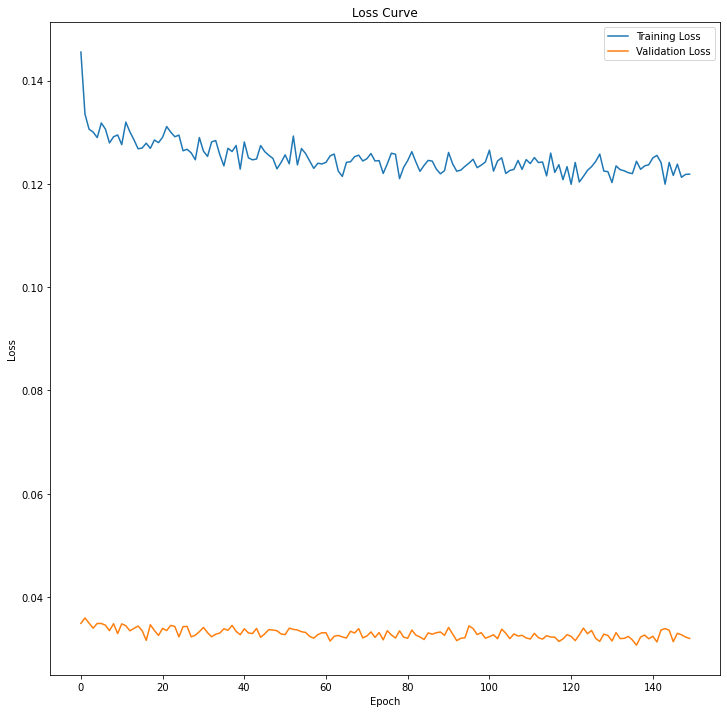

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(tr_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

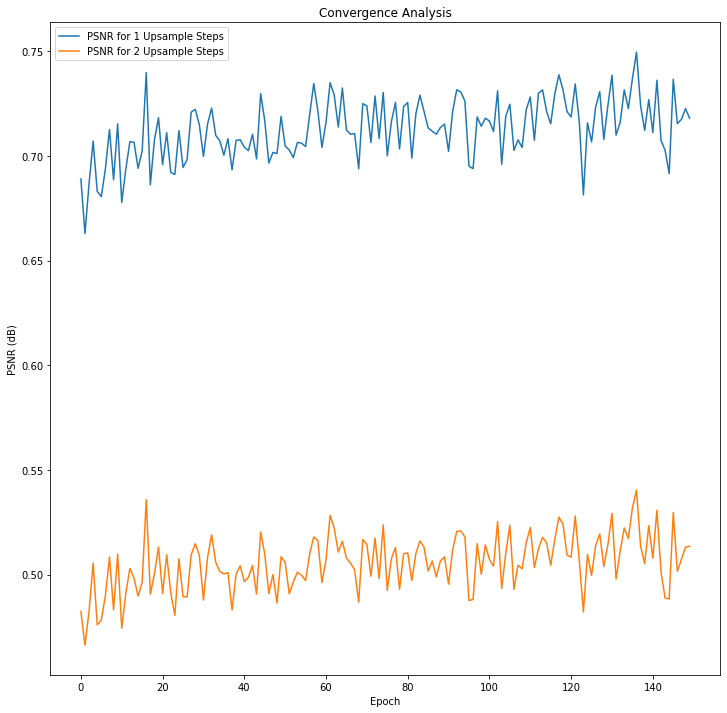

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(val_psnr)
plt.title('Convergence Analysis')
plt.ylabel('PSNR (dB)')
plt.xlabel('Epoch')
plt.legend([f'PSNR for {i+1} Upsample Steps' for i in range(len(val_psnr))])
plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/DIP/LapSRN/good3.pt'
exp.save_model(save_path)

In [ ]:
exp2 = modeling(s=s, d=D, lr=LR)
exp2.load_model(save_path, gpu=False)

Test loss: 0.033, Avg PSNR1: 14.2509 dB, Avg PSNR2: 9.9351 dB, 


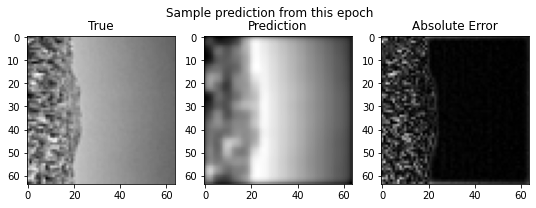

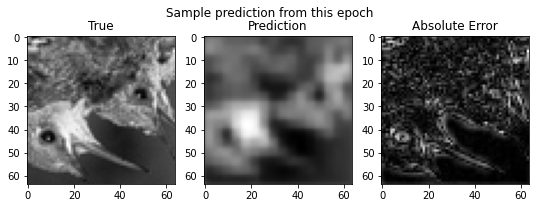

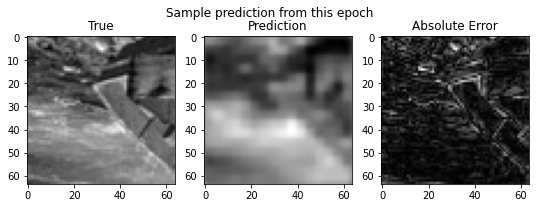

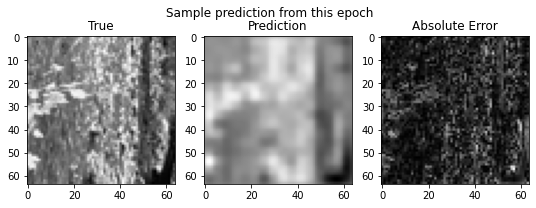

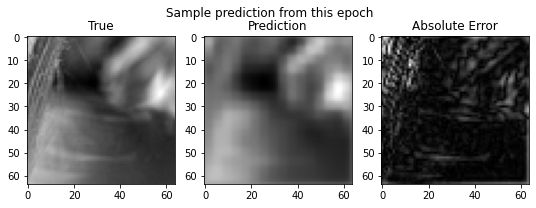

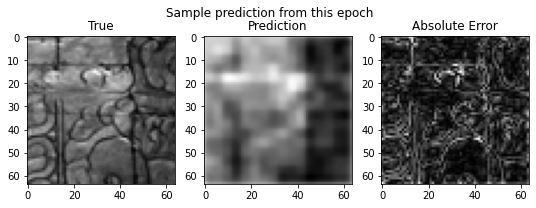

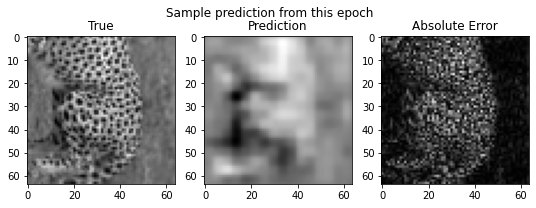

In [ ]:
lss, psnrs = exp2.test(val_ds)

In [ ]:
def upsample(down_factor):
  transform = Compose([
                       Resize(desired_image_size*down_factor, Image.BICUBIC),  # integer division
                       ToTensor()
  ])
  return transform


### Comments:
The model ran was trying to learn how to perform x4 upsampling.
I made a number of changes/assumptions to the implementation to make it run locally, which likely attribute a lot to the drop in ovarall noise reduction:
* Choosing a small batch size
* Sampling each image fewer times (and so we get less data)
* Using a fixed learning rate schedule
* Selecting smaller images

We see that the model was able to learn some relations that would allow it to accurately upsample, yet it had trouble with the high-resolution elements. Looking at results in the paper itself, the authors indicate that their model converged much faster than my model and reached a much higher PSNR . I attempted to play with the hyperparameters a bit of the network to achieve similar results, but with only minor success.

